# Classifier - Imports as Features

The remaining step before being able to train a classifier is to choose the features for the samples. In this case we'll use the static imports (DLL imports) from the binary files.

We start with a simple analysis to the number of features.

In [1]:
from IPython.display import display
import pandas as pd
import numpy as np
import math
import re
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

malware_threshold = 5
data_folder = '../data/'
vendors_file = data_folder + 'vendors.csv.gz'
reports_file = data_folder + 'reports.csv.gz'
dlls_file = data_folder + 'dlls.csv.gz'
selected_imports_file = data_folder + 'selected_imports.csv.gz'
# From notebook 2
top_vendors = ["ESET-NOD32", "McAfee-GW-Edition", "McAfee", "Sophos",
               "VIPRE", "GData", "Kaspersky", "AVG", "BitDefender",
               "Avast", "TrendMicro-HouseCall", "Fortinet", "Emsisoft",
               "DrWeb", "Ikarus", "F-Secure", "MicroWorld-eScan",
               "Symantec", "K7AntiVirus", "K7GW"]

tfidf_token_pattern = u'[^;]+'
vec_stop_words = ['*invalid*']
# Remove imports' extension
def token_preprocessor(s):
    return re.split('\..{0,3}', s)[0]


In [2]:
# Contains all header information
reports = pd.read_csv(reports_file)
reports = reports.set_index('link')
# Sanity check
assert len(reports[~reports.file_type.str.startswith('PE32')]) == 0
reports.drop(['file_name', 'file_size', 'file_type'], axis=1, inplace=True)
reports.date = pd.to_datetime(reports.date, infer_datetime_format=True)
# Now it contains:
# reports = (link, md5, date)

# Contains link as vendors classification
vendors = pd.read_csv(vendors_file, dtype=str)
vendors = vendors.set_index('link')
vendors.dropna(how='all', inplace=True)

# Contains imports
imports = pd.read_csv(dlls_file)
imports = imports.set_index('link')

# Joins on link
# reports_vendors = (link, md5, date, ..vendors..)
reports_vendors = reports.join(vendors, how='inner')

In [3]:
# Filter columns for top vendors only
reports_vendors = reports_vendors[['md5', 'date'] + top_vendors]
# Order by date
reports_vendors.sort_values(by='date', inplace=True)
# Keep the last duplicates
reports_vendors.drop_duplicates(subset='md5', keep='last', inplace=True)
# Turn clean into NaN
reports_vendors.replace('Clean', np.nan, inplace=True)

## Filter malware/goodware

In [4]:
goodware = reports_vendors[reports_vendors.count(axis=1) == 2].index
malware = reports_vendors[reports_vendors.count(axis=1) >= malware_threshold + 2].index

In [5]:
# Get the labeled imports
imports = imports[imports.index.isin(list(goodware) + list(malware))].dropna()

## Imports Statistics

In [6]:
display('Available samples with imports: {}'.format(len(imports)))
display('Goodware samples: {}'.format(len(imports[imports.index.isin(goodware)])))
display('Malware samples: {}'.format(len(imports[imports.index.isin(malware)])))

'Available samples with imports: 194970'

'Goodware samples: 49543'

'Malware samples: 145427'

In [7]:
# Create CountVectorizer to analyse good/malware imports
cv_goodware = CountVectorizer(token_pattern=tfidf_token_pattern, preprocessor=token_preprocessor,
                              stop_words=vec_stop_words)
cv_malware = CountVectorizer(token_pattern=tfidf_token_pattern, preprocessor=token_preprocessor,
                             stop_words=vec_stop_words)

cv_goodware.fit(imports[imports.index.isin(goodware)].dlls)
cv_malware.fit(imports[imports.index.isin(malware)].dlls)

goodware_imports = cv_goodware.get_feature_names()
malware_imports = cv_malware.get_feature_names()

goodware_only_imports = set(goodware_imports).difference(malware_imports)
malware_only_imports = set(malware_imports).difference(goodware_imports)
common_imports = set(goodware_imports).intersection(malware_imports)

display('Number of unique goodware imports: {}'.format(len(goodware_imports)))
display('Number of unique malware imports: {}'.format(len(malware_imports)))
display('Goodware only imports: {}'.format(len(goodware_only_imports)))
display('Malware only imports: {}'.format(len(malware_only_imports)))
display('Common imports: {}'.format(len(common_imports)))

'Number of unique goodware imports: 1024'

'Number of unique malware imports: 432'

'Goodware only imports: 807'

'Malware only imports: 215'

'Common imports: 217'

### Frequency of exclusive imports

In [8]:
# Create CountVectorizer for goodware only imports, generate frequency matrix
cv_goodware = CountVectorizer(token_pattern=tfidf_token_pattern, vocabulary=goodware_only_imports,
                              preprocessor=token_preprocessor, stop_words=vec_stop_words)
matrix_tf_goodware = cv_goodware.fit_transform(imports[imports.index.isin(goodware)].dlls)
matrix_goodware = np.sum(matrix_tf_goodware, axis=0, dtype=int)
matrix_goodware = np.divide(matrix_goodware, np.amax(matrix_goodware))
matrix_goodware = np.array_split(np.array(matrix_goodware)[0], int(math.sqrt(len(cv_goodware.get_feature_names()))*0.5))

# Create CountVectorizer for malware only imports, generate frequency matrix
cv_malware = CountVectorizer(token_pattern=tfidf_token_pattern, vocabulary=malware_only_imports,
                             preprocessor=token_preprocessor, stop_words=vec_stop_words)
matrix_tf_malware = cv_malware.fit_transform(imports[imports.index.isin(malware)].dlls)
matrix_malware = np.sum(matrix_tf_malware, axis=0, dtype=int)
matrix_malware = np.divide(matrix_malware, np.amax(matrix_malware))
matrix_malware = np.array_split(np.array(matrix_malware)[0], int(math.sqrt(len(cv_malware.get_feature_names()))*0.5))

#### Goodware imports

The following graph shows the presence of each import for goodware samples. A darker square means a more frequent import, whereas a lighter square means less frequent.

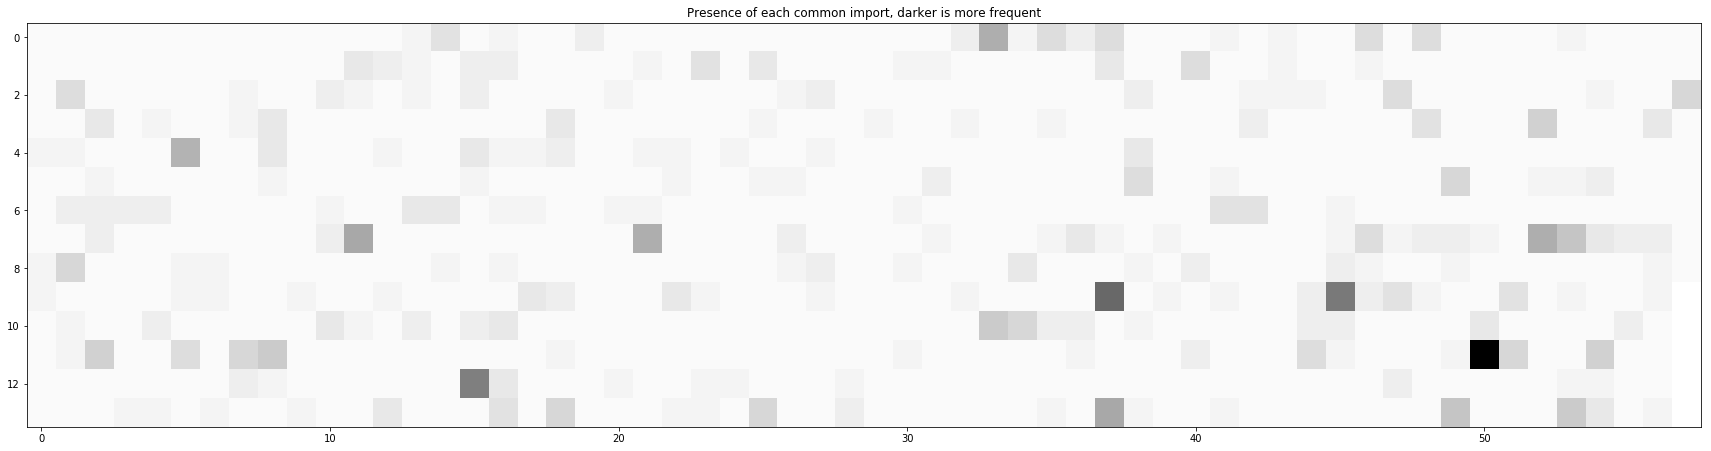

In [9]:
fig, ax1 = plt.subplots(figsize=(30, 30))
ax1.set_title('Presence of each common import, darker is more frequent')
plt.imshow(pd.DataFrame(matrix_goodware).fillna(0), cmap='binary', vmin=0, vmax=1)
plt.show()

#### Malware imports

The following graph shows the presence of each import for malware samples. A darker square means a more frequent import, whereas a lighter square means less frequent.

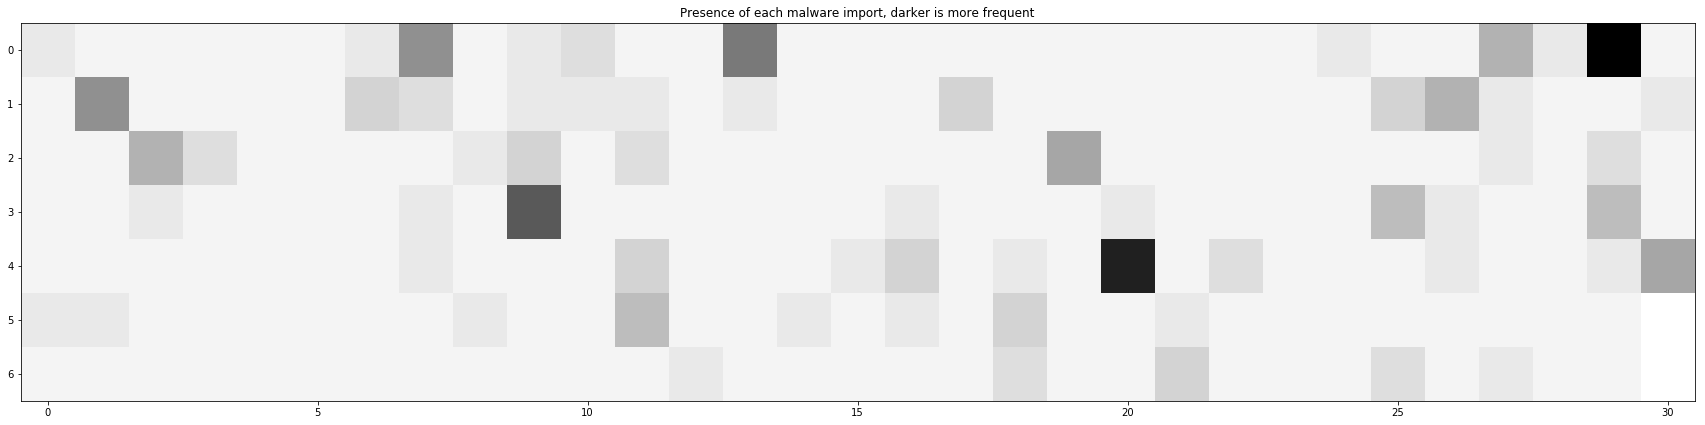

In [10]:
fig, ax1 = plt.subplots(figsize=(30, 30))
ax1.set_title('Presence of each malware import, darker is more frequent')
plt.imshow(pd.DataFrame(matrix_malware).fillna(0), cmap='binary', vmin=0, vmax=1)
plt.show()

### Common imports

#### Frequency

The following graph shows the presence of each common import for all samples. A darker square means a more frequent import, whereas a lighter square means less frequent.

In [11]:
# Create CountVectorizer with only common imports
cv_common = CountVectorizer(token_pattern=tfidf_token_pattern, vocabulary=common_imports,
                            preprocessor=token_preprocessor, stop_words=vec_stop_words)
matrix_tf_common = cv_common.fit_transform(imports.dlls)
matrix_common = np.sum(matrix_tf_common, axis=0, dtype=int)
matrix_common = np.divide(matrix_common, np.amax(matrix_common))
matrix_common = np.array_split(np.array(matrix_common)[0], int(math.sqrt(len(cv_common.get_feature_names()))*0.5))

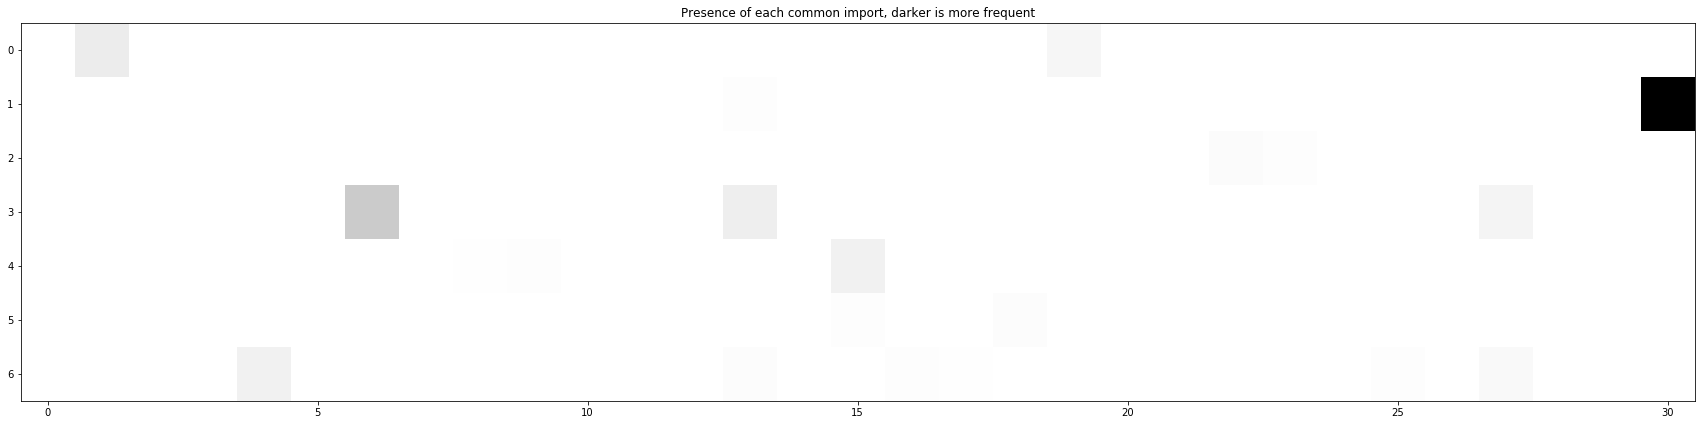

In [12]:
fig, ax1 = plt.subplots(figsize=(30, 30))
ax1.set_title('Presence of each common import, darker is more frequent')
plt.imshow(pd.DataFrame(matrix_common).fillna(0), cmap='binary', vmin=0, vmax=1)
plt.show()

#### Difference in common imports

In [13]:
cv_common = CountVectorizer(token_pattern=tfidf_token_pattern, vocabulary=common_imports,
                            preprocessor=token_preprocessor, stop_words=vec_stop_words)
cv_common.fit(imports.dlls)

matrix_goodware = np.sum(cv_common.transform(imports[imports.index.isin(goodware)].dlls), axis=0, dtype=int)
matrix_malware = np.sum(cv_common.transform(imports[imports.index.isin(malware)].dlls), axis=0, dtype=int)

# Normalize the matrixes against presence of imports for each class
matrix_goodware = np.divide(matrix_goodware, len(imports[imports.index.isin(goodware)]))
matrix_malware = np.divide(matrix_malware, len(imports[imports.index.isin(malware)]))

# Normalize by the sum of both matrices
matrix_divisor = np.add(matrix_goodware, matrix_malware)
matrix_goodware = np.divide(matrix_goodware, matrix_divisor)
matrix_malware = np.divide(matrix_malware, matrix_divisor)

# Create difference matrix
matrix = np.subtract(matrix_malware, matrix_goodware)
matrix2 = np.array_split(np.array(matrix)[0], int(math.sqrt(len(cv_common.get_feature_names()))*0.5))

The following graph shows the tendency for each feature individually. Darker reds means the feature is more present in malware, whereas darker blues indicate a feature is more present in goodware.

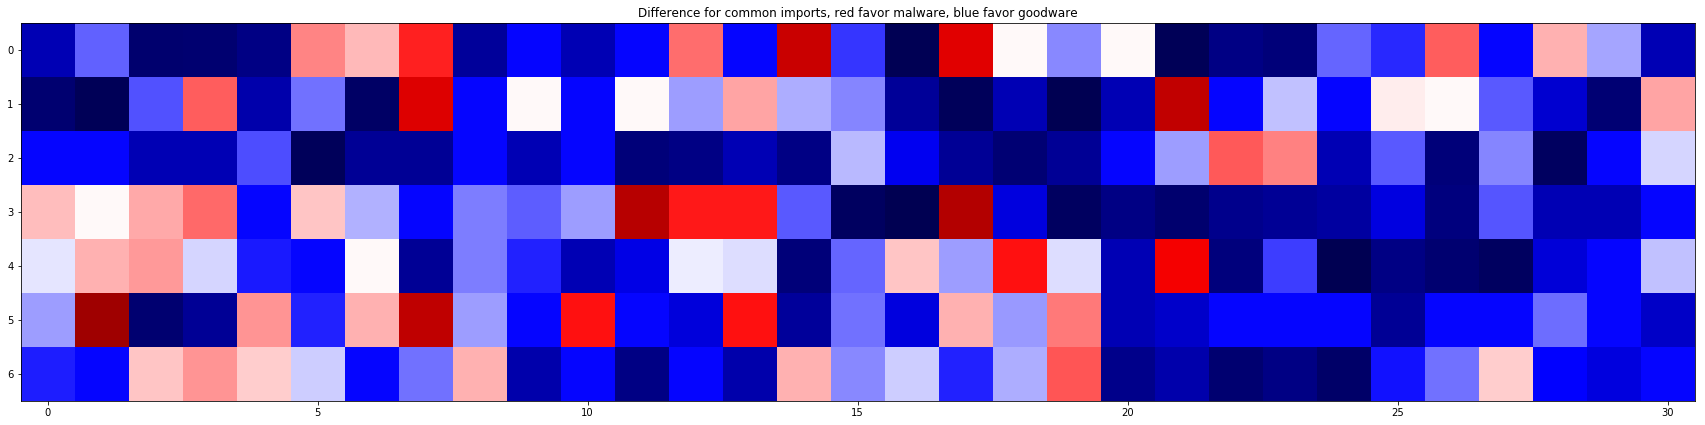

In [14]:
fig, ax1 = plt.subplots(figsize=(30, 30))
ax1.set_title('Difference for common imports, red favor malware, blue favor goodware')
plt.imshow(pd.DataFrame(matrix2), cmap='seismic', vmin=-1, vmax=1)
plt.show()

## Feature Selection

We can filter down the number of imports to 200 from each class (goodware and malware) for a total of 400 exclusive imports.

In [15]:
# Filter top 200 from malware/goodware only imports
import_goodware = pd.Series(index=cv_goodware.vocabulary_.keys(),
                            data=np.array(np.sum(matrix_tf_goodware, axis=0, dtype=int))[0],
                            dtype=int)
top_goodware_imports = import_goodware.sort_values(ascending=False)[:200].index

import_malware = pd.Series(index=cv_malware.vocabulary_.keys(),
                            data=np.array(np.sum(matrix_tf_malware, axis=0, dtype=int))[0],
                            dtype=int)
top_malware_imports = import_malware.sort_values(ascending=False)[:200].index

In [16]:
# Filter top 200 from common imports
import_common = pd.Series(index=cv_common.vocabulary_.keys(),
                          data=np.array(np.abs(matrix))[0])
top_common_imports = import_common[:200].index

In [17]:
# Selected imports
selected_imports = pd.DataFrame(list(top_goodware_imports) + list(top_malware_imports) + list(top_common_imports))
selected_imports.to_csv(selected_imports_file, compression='gzip')

## Conclusion

We provided a simple metric for import selection. Split the imports into common and exclusive imports. Exclusive imports for malware/goodware are selected based on their frequency in the corresponding class, in this case the top 200 more frequent and selected.

For common imports, a comparison between the frequency they appear in malware vs goodware is made. Common imports that are mode one-sided are more descriptive, hence the top 200 more descritive imports are selected.